### Модель
1. Одномерная модель, у каждого неориентированного ребра свой вес, вершин n=100.
2. Из равномерного распределения каждые k=20 шагов какой-то вершине приходит 1 информации.
3. Каждый шаг вся информация агента дублируется его соседу с вероятностью ребра. Затем у всех информация уменьшается на a=5%.
4. RL модель на каждом шаге проверяет ровно 1 агента и узнает, сколько у него информации.
5. Цель RL модели -- найти агента, от которого идет максимум информации (или проранжировать).

In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import clear_output
import time

In [4]:
class InfoPropagationEnv(gym.Env):
    """
    Среда для моделирования распространения информации по одномерной модели
    и поиска источника распространения.
    """

    def __init__(self, n=100, decay_rate=0.05, info_interval=20, max_steps=500, random_seed=np.random.randint(0, 10000)):
        super(InfoPropagationEnv, self).__init__()

        # Параметры среды
        self.n = n  # количество вершин
        self.decay_rate = decay_rate  # скорость затухания информации (a=10%)
        self.info_interval = info_interval  # интервал добавления новой информации (k=20)
        self.max_steps = max_steps  # максимальное количество шагов в эпизоде

        # Пространство действий:
        # 0 до n-1: выбор вершины для проверки
        # n до 2n-1: выбор вершины как ответ (источник)
        self.action_space = spaces.Discrete(2 * n)

        # Пространство наблюдений
        self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf, shape=(n,), dtype=np.float32
            )  # [info_value] для последних проверок

        # Инициализация среды
        self.reset(seed=random_seed)

    def reset(self, seed=None, options=None):
        """Сброс среды в начальное состояние."""
        # Если seed передан, устанавливаем его для NumPy
        if seed is not None:
            np.random.seed(seed)

        # Генерация случайных весов для рёбер
        self.edge_weights = np.random.uniform(0, 1.0, self.n - 1)

        # Инициализация значений информации в каждой вершине
        self.info_values = np.zeros(self.n, dtype=np.float32)

        # Отслеживание шагов
        self.step_count = 0

        # Отслеживание источников информации и количества полученной информации
        self.source_history = []
        self.source_contribution = np.zeros(self.n, dtype=np.float32)

        # История запросов агента [вершина, значение_информации]
        self.query_history = np.full(self.n, 0, dtype=np.float32)

        # Флаги завершения эпизода
        self.done = False
        self.truncation_flag = False

        # Вычисление начального наблюдения
        observation = self._get_observation()

        # Дополнительная информация
        info = {}

        return observation, info

    def _get_observation(self):
        """Вычисление текущего наблюдения."""
        return self.query_history.copy()

    def step(self, action):
        """
        Выполнение одного шага в среде.

        Args:
            action (int):
                - 0 до n-1: выбор вершины для проверки
                - n до 2n-1: выбор вершины как ответ (источник)

        Returns:
            observation: новое наблюдение
            reward: полученная награда
            done: флаг завершения эпизода
            info: дополнительная информация
        """
        # Разделяем действия на запрос и ответ
        if action < self.n:
            # Запрос информации о вершине
            queried_vertex = action
            reward = self._calculate_query_reward(queried_vertex)
            self.query_history[queried_vertex] = self.info_values[queried_vertex]
        else:
            # Ответ на вопрос о источнике информации
            answer_vertex = action - self.n
            reward = self._calculate_answer_reward(answer_vertex)
            self.reset()
            self.done = True  # Эпизод завершается после ответа

        # Распространение и затухание информации
        self._propagate_information()

        # Обновляем наблюдение
        observation = self._get_observation()

        # Проверка завершения эпизода
        if self.step_count >= self.max_steps:
            self.truncation_flag = True

        # Дополнительная информация
        info = {}

        return observation, reward, self.done, self.truncation_flag, info

    def _propagate_information(self):
        """Распространение и затухание информации."""
        # Копия текущего состояния для расчета распространения
        current_info = self.info_values.copy()

        # Расчет распространения информации через ребра
        for i in range(self.n):
            # Обработка соседей (левого и правого)
            # Левый сосед
            if i > 0 and current_info[i] > 0:
                # Вероятность передачи = вес ребра
                transfer_happens = np.random.rand() < self.edge_weights[i-1]
                self.info_values[i-1] = max(current_info[i] * transfer_happens, self.info_values[i-1])

            # Правый сосед
            if i < self.n - 1 and current_info[i] > 0:
                # Вероятность передачи = вес ребра
                transfer_happens = np.random.rand() < self.edge_weights[i]
                self.info_values[i+1] = max(current_info[i] * transfer_happens, self.info_values[i+1])

        # Затухание информации
        self.info_values *= (1 - self.decay_rate)

        # Добавляем информацию в систему
        if self.step_count % self.info_interval == 0:
            self.info_values[np.random.randint(0, self.n-1)] += 1

        # Именно здесь обозначаем, что шаг сделан
        self.step_count += 1

    # Найдем наиболее важные вершины методом монте-карло моделирования (да, тупо, знаю)
    def popularity_sort(self, repeat_factor=1000, distribution_steps=20):
        list_mean_info = []
        for i in range(self.n):
            mean_info = 0
            for _ in range(repeat_factor):
                left = i
                right = i
                all_info_i = 1
                current_info = 1
                for _ in range(distribution_steps):
                    current_info *= (1 - self.decay_rate)
                    if left != 0:
                        if np.random.rand() < self.edge_weights[left-1]:
                            left -= 1
                            all_info_i += current_info
                    if right != self.n-1:
                        if np.random.rand() < self.edge_weights[right]:
                            right += 1
                            all_info_i += current_info
                mean_info += all_info_i
            list_mean_info.append(mean_info/repeat_factor)
        indices = np.argsort(list_mean_info)[::-1]
        mean_distribution_info = np.sort(list_mean_info)[::-1]
        return indices, mean_distribution_info

    def _calculate_query_reward(self, queried_vertex):
        if self.step_count < 100:
          return 0
        else:
          return -1 # Небольшой штраф за проверку

    def _calculate_answer_reward(self, answer_vertex):
        """Вычисление награды за ответ."""
        # Находим вершину, которая была источником наибольшего количества информации
        popularity_sort = self.popularity_sort()

        #index = np.where(popularity_sort[0] == answer_vertex)
        #delta = (self.n//2 - index[0][0])

        # Можно попробовать
        info_distribution = popularity_sort[1][np.where(popularity_sort[0] == answer_vertex)[0][0]]
        delta = (info_distribution - popularity_sort[1][0] + 1) * 100

        print('self.step_count', self.step_count, 'answer_vertex', answer_vertex, 'reward', delta)

        return delta


### Визуализация работы среды

Сейчас я могу изучить работу среды в целом. Однако я не могу целостно посотреть, что произошло в конкретной среде, так как я ее каждый раз генерирую заново, а не работаю с логами - это недочет. Чтобы это исправить, в начале нужно сделать лист с env.info_values, а потом идти по этому листу.

In [76]:
env = InfoPropagationEnv(n=100, info_interval=20, decay_rate=0.05, max_steps=5000, random_seed=100)
info_values_list = []
steps = 2000
for i in tqdm(range(steps)):
    info_values_list.append(env.info_values.copy())
    env._propagate_information()

100%|██████████| 2000/2000 [00:00<00:00, 2911.88it/s]


Поймем, расходится ли суммарная информация в системе.

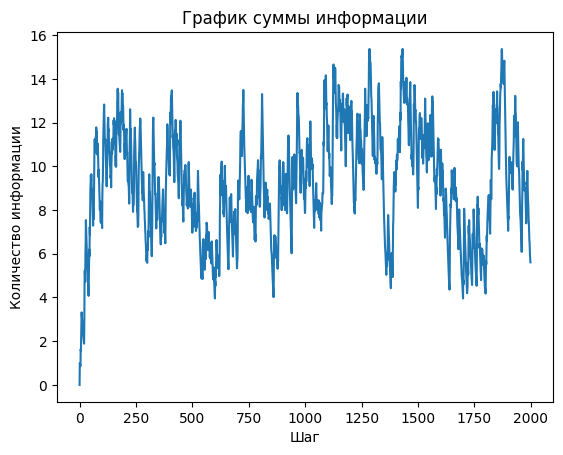

In [38]:
plt.plot(range(steps), np.sum(info_values_list, axis=1))
plt.title("График суммы информации")
plt.xlabel("Шаг")
plt.ylabel("Количество информации")
plt.show()

Проиллюстрируем, что именно происходит в системе на каждом шаге

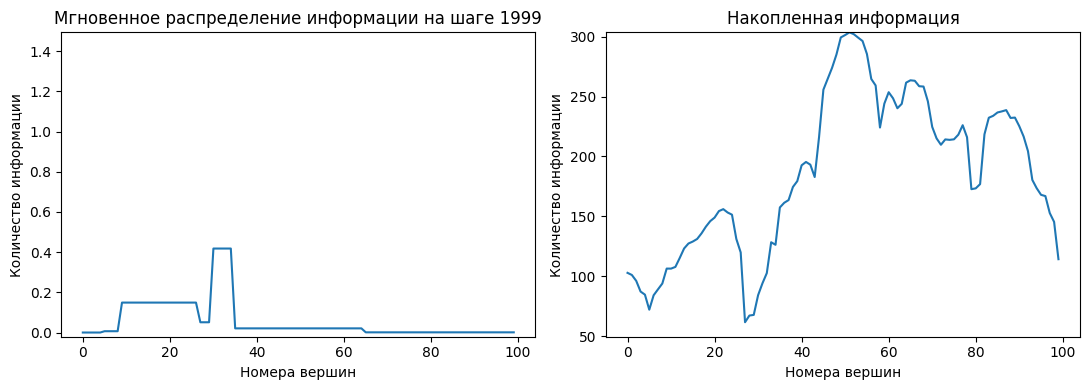

In [39]:
from IPython.display import clear_output
import time

left = steps-10
right = steps
delay = 0
max_information = np.max(info_values_list)
max_cumsum = np.max(np.cumsum(info_values_list, axis=0)[-1])

for i in range(left, right):
    clear_output(wait=True)
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))

    axs[0].plot(range(len(info_values_list[i])), info_values_list[i])
    axs[0].set_title(f'Мгновенное распределение информации на шаге {i}')
    axs[0].set_xlabel("Номера вершин")
    axs[0].set_ylabel("Количество информации")
    axs[0].set_ylim(ymax=max_information)

    axs[1].plot(range(len(info_values_list[i])), np.cumsum(info_values_list[:i+1], axis=0)[-1])
    axs[1].set_title('Накопленная информация')
    axs[1].set_xlabel("Номера вершин")
    axs[1].set_ylabel("Количество информации")
    axs[1].set_ylim(ymax=max_cumsum)

    plt.tight_layout()
    plt.show()
    time.sleep(delay)

Безуспешно пытаемся понять, почему такая накопленная информация

In [40]:
cumsum = np.cumsum(info_values_list, axis=0)[-1]
indices_cumsum = np.argsort(cumsum)[::-1]
indices_cumsum

array([51, 52, 50, 49, 53, 54, 55, 48, 47, 46, 56, 65, 66, 64, 57, 67, 68,
       45, 60, 61, 69, 59, 63, 62, 87, 86, 85, 84, 89, 83, 88, 77, 90, 70,
       58, 82, 76, 91, 44, 78, 71, 75, 73, 74, 72, 92, 41, 42, 40, 43, 93,
       39, 81, 38, 94, 80, 79, 95, 96, 37, 36, 35, 22, 21, 23, 97, 24, 20,
       19, 98, 18, 17, 16, 25, 15, 33, 14, 34, 13, 26, 12, 99, 11,  9, 10,
        0, 32,  1,  2, 31,  8,  7,  3,  4, 30,  6,  5, 29, 28, 27])

In [80]:
env.popularity_sort()

(array([51, 52, 87, 86, 50, 88, 89, 49, 85, 53, 84, 66, 90, 91, 68, 64, 83,
        67, 69, 65, 54, 48, 82, 70, 71, 74, 72, 73, 75, 18, 55, 19, 20, 92,
        21, 76, 17, 77, 22, 16, 47, 63, 46, 62, 15, 78, 56, 23, 61, 80, 45,
        93, 79, 81, 60, 14, 94, 24, 95, 59, 57, 96, 11, 10, 13, 12, 39, 40,
         9, 41, 38, 42, 44, 58, 43, 97,  8, 25,  7, 98, 37,  6, 36, 35, 26,
        33, 32, 34, 99, 31, 30,  2,  3,  5,  4,  1,  0, 29, 28, 27]),
 array([10.23656573, 10.17764679, 10.1769917 , 10.13521943, 10.1253092 ,
        10.11376951, 10.10821436,  9.97189342,  9.87758412,  9.82702021,
         9.82118032,  9.82075079,  9.81912325,  9.71276314,  9.70898308,
         9.68770665,  9.68210083,  9.66870325,  9.6457104 ,  9.6255095 ,
         9.60082364,  9.49720929,  9.33510693,  9.31372876,  9.29518712,
         9.28633428,  9.26530805,  9.25944853,  9.18702182,  9.09385287,
         9.08169242,  9.07746849,  9.05009785,  9.04214262,  9.03707007,
         9.01463911,  8.82863308,  8.82

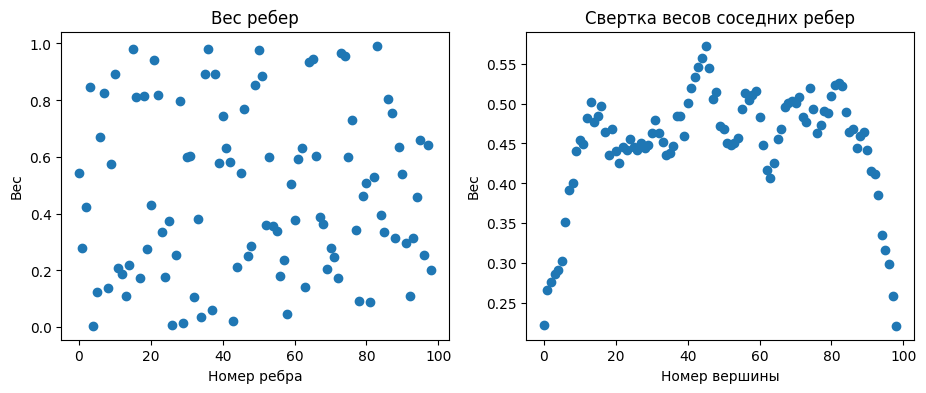

array([45, 44, 43, 46, 42, 82, 81, 83, 74, 41, 59, 48, 56, 58, 80, 71, 47,
       57, 69, 13, 70, 68, 40, 16, 67, 75, 55, 78, 84, 79, 15, 37, 38, 60,
       72, 12, 31, 73, 14, 77, 49, 19, 50, 66, 86, 85, 89, 17, 32, 30, 76,
       88, 39, 54, 65, 24, 10, 33, 53, 27, 51, 11, 29, 52, 61, 36, 25, 22,
       28, 87, 26, 23, 90,  9, 20, 35, 34, 18, 21, 64, 62, 91, 92, 63,  8,
        7, 93,  6, 94, 95,  5, 96,  4,  3,  2,  1, 97,  0, 98])

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

axs[0].scatter(range(len(env.edge_weights)), env.edge_weights)
axs[0].set_title(f'Вес ребер')
axs[0].set_xlabel("Номер ребра")
axs[0].set_ylabel("Вес")

data = np.array(env.edge_weights.copy())
window_size = 20
window = np.ones(window_size) / window_size
moving_average = np.convolve(data, window, 'same')

axs[1].scatter(range(len(moving_average)), moving_average)
axs[1].set_title(f'Свертка весов соседних ребер')
axs[1].set_xlabel("Номер вершины")
axs[1].set_ylabel("Вес")
plt.show()

np.argsort(moving_average)[::-1]

### Непосредственно обучение

In [5]:
# Создаем среду
env = InfoPropagationEnv(n=100, info_interval=20, decay_rate=0.05, max_steps=5000, random_seed=100)

In [6]:
# Векторизуем среду (если нужно) -- для тяжеловесной среды
# env = make_vec_env(InfoPropagationEnv, n_envs=1)

# Создаем модель с использованием политики ActorCriticPolicy
model = PPO("MlpPolicy", env, verbose=1)

# Обучаем модель
model.learn(total_timesteps=25000, log_interval=1)

# Сохраняем модель
model.save("ppo_info_propagation_2")

# Удаляем модель, чтобы продемонстрировать загрузку
del model

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
self.step_count 1 answer_vertex 66 reward 80.2287972549312
self.step_count 4 answer_vertex 84 reward -37.57178290452021
self.step_count 0 answer_vertex 90 reward -50.34109697264579
self.step_count 0 answer_vertex 65 reward -468.20063332578326
self.step_count 2 answer_vertex 57 reward -276.811542228626
self.step_count 0 answer_vertex 35 reward -214.4828322355984
self.step_count 1 answer_vertex 74 reward -40.61238358077475
self.step_count 1 answer_vertex 37 reward -403.52431599137503
self.step_count 3 answer_vertex 19 reward -209.89979324225007
self.step_count 0 answer_vertex 5 reward -686.1851751062163
self.step_count 0 answer_vertex 61 reward -781.4314235183415
self.step_count 1 answer_vertex 29 reward -288.8461827268191
self.step_count 0 answer_vertex 35 reward 89.69135459872568
self.step_count 0 answer_vertex 67 reward 91.86262786772926
self.step_count 5 answer_vertex 84 reward -607.39885051

KeyboardInterrupt: 

In [ ]:
# Загружаем модель
model = PPO.load("ppo_info_propagation")

# Запускаем среду и тестируем модель
obs, _ = env.reset()
for _ in range(500):
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(action)

self.step_count 0 answer_vertex 96 reward -16
action 196
self.step_count 1 answer_vertex 40 reward -19
action 140
self.step_count 1 answer_vertex 6 reward -26
action 106
action 40
action 90
self.step_count 3 answer_vertex 8 reward 30
action 108
action 23
self.step_count 2 answer_vertex 41 reward 44
action 141
action 46
action 57
self.step_count 3 answer_vertex 13 reward 7
action 113
self.step_count 1 answer_vertex 16 reward -7
action 116
self.step_count 1 answer_vertex 98 reward -43
action 198
self.step_count 1 answer_vertex 40 reward -16
action 140
action 30
action 12
action 98
action 32
action 21
self.step_count 6 answer_vertex 19 reward 50
action 119
action 91
self.step_count 2 answer_vertex 32 reward 2
action 132
action 67
action 63
action 62
action 85
self.step_count 5 answer_vertex 85 reward 29
action 185
action 69
action 38
action 83
action 86
action 44
self.step_count 6 answer_vertex 40 reward -39
action 140
action 35
action 33
action 84
self.step_count 4 answer_vertex 57 rewar

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-67eec11c2f32>", line 8, in <cell line: 0>
    obs, rewards, dones, _, info = env.step(action)
                                   ^^^^^^^^^^^^^^^^
  File "<ipython-input-4-95a1c967acf5>", line 91, in step
    reward = self._calculate_answer_reward(answer_vertex)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-4-95a1c967acf5>", line 172, in _calculate_answer_reward
    popularity_sort = self.popularity_sort()
                      ^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-4-95a1c967acf5>", line None, in popularity_sort
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in 